In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from argparse import ArgumentParser

from keras.models import Model
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Activation, Input, UpSampling2D, concatenate, BatchNormalization
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
from keras.optimizers import Adam
import keras.backend as K
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

### Tensorflow dependencies ###
import tensorflow as tf

2023-09-23 09:28:32.074302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class DataLoader:
    def __init__(self, data_dir, unlabelled_data_dir, batch_size, u_batch_size, val_ratio):
        # data_dir = '/Users/lanchipham/LungSegment/'
        self.data_dir = data_dir
        self.img_dir = os.path.join(data_dir, 'images')
        self.mask_dir = os.path.join(data_dir, 'masks')

        self.batch_size = batch_size
        self.u_batch_size = u_batch_size
        self.val_ratio = val_ratio

        # Pair the images and the mask
        counter = 0
        self.image_files = []
        self.mask_files = []
        self.unlabelled_img_files = self.__get_img_in_dir(unlabelled_data_dir)
        
        
        if(len(self.unlabelled_img_files) == 0):
            raise Exception('No images in unlabelled image folder')

        for mask in self.__get_img_in_dir(self.mask_dir):
            filename = mask.split('/')[-1]
            
            respective_img = f'{self.img_dir}/{filename}'
            if(respective_img in self.__get_img_in_dir(self.img_dir)):
                self.mask_files.append(mask)
                self.image_files.append(respective_img)
                
        if(len(self.image_files) == 0):
            raise Exception('No images in labelled image folder')
        
        print(f'Number of matching mask-image pairs : {len(self.mask_files)}')

    def __get_img_in_dir(self, directory):
        extensions = ["png", "jpeg", "jpg", "bmp", "tif"]
        imgs = []
        
        for ext in extensions:
            imgs += glob.glob(os.path.join(directory, f'*.{ext}'))

        return imgs
    
    @staticmethod
    def map_fn(img, size=256):
        img = tf.image.resize(img, [size, size])
        img = tf.clip_by_value(img, 0, 255)
        
        mean = tf.math.reduce_mean(img)
        std = tf.math.reduce_std(img)
        img = (img - mean) / std

        return img

    @staticmethod
    def parse_fn(img_file, mask_file):
        img = tf.io.read_file(img_file)
        img = tf.image.decode_png(img, 3)
        img = DataLoader.map_fn(img)

        mask = tf.io.read_file(mask_file)
        mask = tf.image.decode_png(mask, 1)
        mask = tf.cast(mask, dtype=tf.float32)
        mask = tf.image.resize(mask, [256, 256])
        mask = mask / 255.0

        return img, mask
    
    @staticmethod
    def parse_unlabelled_data_fn(img_file):
        # Read image and perform weak and strong augmentation
        img = tf.io.read_file(img_file)
        img = tf.image.decode_png(img, 3)
        
        # Weakly augmented - for now no weakly aug, just leave the original image
        weak_aug = img
        
        # Strongly augmented - random brightness and contrast
        seed = np.random.randint(1000)
        strong_aug = tf.image.random_jpeg_quality(img, 0, 10, seed=seed)
        strong_aug = tf.image.random_brightness(strong_aug, max_delta=0.5, seed=seed)
        strong_aug = tf.image.random_saturation(strong_aug, 0.5, 1.0, seed)
        strong_aug = tf.keras.layers.GaussianNoise(10)(strong_aug)
        
        # Normalize and resize
        weak_aug = DataLoader.map_fn(weak_aug)
        strong_aug = DataLoader.map_fn(strong_aug)

        return weak_aug, strong_aug

    def get_train_val_datasets(self):
        X_train, X_test, Y_train, Y_test = train_test_split(self.image_files, self.mask_files, test_size=self.val_ratio)
        self.train_steps = len(X_train) // self.batch_size + 1
        self.val_steps = len(X_test) // self.batch_size + 1

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
        train_dataset = train_dataset.map(DataLoader.parse_fn)
        train_dataset = train_dataset.repeat()
        train_dataset = train_dataset.batch(self.batch_size)
        train_dataset = train_dataset.take(self.train_steps)

        val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
        val_dataset = val_dataset.map(DataLoader.parse_fn)
        val_dataset = val_dataset.repeat()
        val_dataset = val_dataset.batch(self.batch_size)
        val_dataset = val_dataset.take(self.val_steps)

        return train_dataset, val_dataset
    
    def get_unlabelled_dataset(self):
        # Unlabelled dataset will return weakly augmented and strongly augmented images
        u_dataset = tf.data.Dataset.from_tensor_slices(self.unlabelled_img_files)
        u_dataset = u_dataset.map(DataLoader.parse_unlabelled_data_fn)
        u_dataset = u_dataset.repeat()
        u_dataset = u_dataset.batch(self.u_batch_size)
        
        return u_dataset

In [3]:
data_dir = '/Users/lanchipham/LungSegment/data/Montgomery'
unlabelled_data_dir = '/Users/lanchipham/LungSegment/data/Montgomery/images'
batch_size = 16
u_batch_size = 32
val_ratio = 0.3333


In [4]:
loader = DataLoader(data_dir, unlabelled_data_dir, batch_size, u_batch_size, val_ratio)

Number of matching mask-image pairs : 138


In [5]:
u_dataset = loader.get_unlabelled_dataset()

2023-09-23 09:28:58.477397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

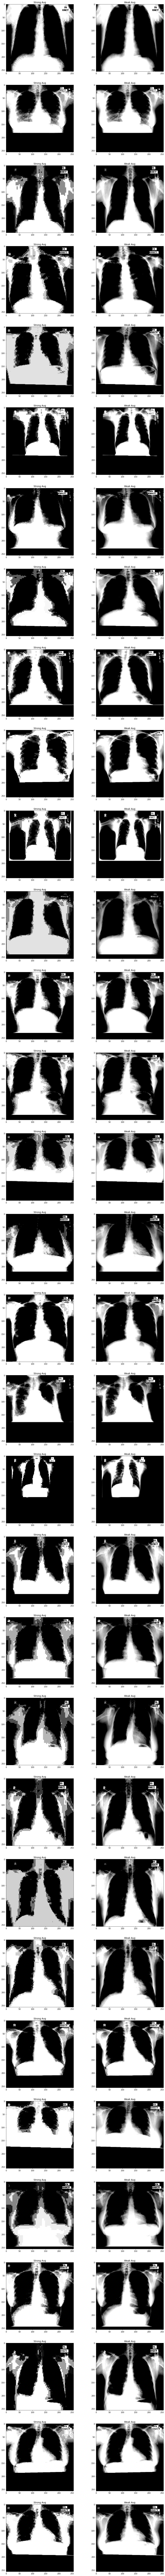

In [6]:
weak_augs, strong_augs = next(iter(u_dataset))
fig, ax = plt.subplots(32, 2, figsize=(16, 256))

for i in range(u_batch_size):
    strong = np.clip(0, 1.0, strong_augs[i].numpy())
    weak = np.clip(0, 1.0, weak_augs[i])
    
    ax[i][0].imshow(strong)
    ax[i][1].imshow(weak)

    ax[i][0].set_title('Strong Aug')
    ax[i][1].set_title('Weak Aug')

plt.show()

In [7]:
# fig, axs = plt.subplots(figsize = (15,8))

# df_losses = pd.read_csv('/Users/lanchipham/LungSegment/checkpoints/lung-segmentation/losses.csv')
# training_loss = df_losses['train']
# validation_loss = df_losses['val']

# epochs_count = range(1, len(training_loss) + 1)

# axs.plot(epochs_count, training_loss, 'r--')
# axs.plot(epochs_count, validation_loss, 'b-')
# axs.legend(['Training Loss', 'Validation Loss'])

## Training Data for Segmentation

In [8]:
import glob

data_dir = '/Users/lanchipham/LungSegment/data/Montgomery'
unlabelled_data_dir = '/Users/lanchipham/LungSegment/data/Montgomery/images'

cxr_paths = glob.glob(os.path.join(data_dir, 'images', '*.png'))
cxr_images = []
for c_path in cxr_paths:
    image_path = c_path
    mask_path = os.path.join(data_dir, 'masks', os.path.basename(c_path))  # Use a single mask path for each image
    cxr_images.append((image_path, [mask_path]))

print('CXR Images', len(cxr_paths), cxr_paths[0])
print(cxr_images[0])


CXR Images 138 /Users/lanchipham/LungSegment/data/Montgomery/images/MCUCXR_0023_0.png
('/Users/lanchipham/LungSegment/data/Montgomery/images/MCUCXR_0023_0.png', ['/Users/lanchipham/LungSegment/data/Montgomery/masks/MCUCXR_0023_0.png'])


In [9]:
from skimage.io import imread as imread_raw
from skimage.transform import resize
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore', category=UserWarning, module='skimage') # skimage is really annoying
OUT_DIM = (512, 512)
def imread(in_path, apply_clahe = False):
    img_data = imread_raw(in_path)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    if apply_clahe:
        clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
        n_img = clahe_tool.apply(n_img)
    return np.expand_dims(n_img, -1)


In [10]:

img_vol, seg_vol = [], []
for img_path, s_paths in tqdm(cxr_images):
    try:
        img = imread(img_path)
        # Remove the extra singleton dimension from images
        img = np.squeeze(img, axis=-1)
        img_vol.append(img)

        # Initialize an empty segmentation mask if not available
        max_seg = np.zeros_like(img)

        for s_path in s_paths:
            if os.path.exists(s_path):
                seg = imread(s_path, apply_clahe=False)
                max_seg = np.maximum(max_seg, seg)

        seg_vol.append(max_seg)
    except Exception as e:
        print(f"Error loading image {img_path}: {str(e)}")

if len(img_vol) == 0 or len(seg_vol) == 0:
    print("No images or segmentations were successfully loaded.")
else:
    img_vol = np.stack(img_vol, 0)
    seg_vol = np.stack(seg_vol, 0)
    print('Images', img_vol.shape, 'Segmentations', seg_vol.shape)

print(img_vol.shape)
print (seg_vol.shape)

100%|██████████| 138/138 [00:15<00:00,  9.07it/s]


Images (138, 512, 512, 3) Segmentations (138, 512, 512, 3)
(138, 512, 512, 3)
(138, 512, 512, 3)


In [11]:
# # Remove the extra dimension of size 1
# img_vol = np.squeeze(img_vol, axis=-1)
# seg_vol = np.squeeze(seg_vol, axis=-1)

# # Now, the shape of img_vol and seg_vol should be (138, 512, 512, 3)
# print('Images', img_vol.shape, 'Segmentations', seg_vol.shape)


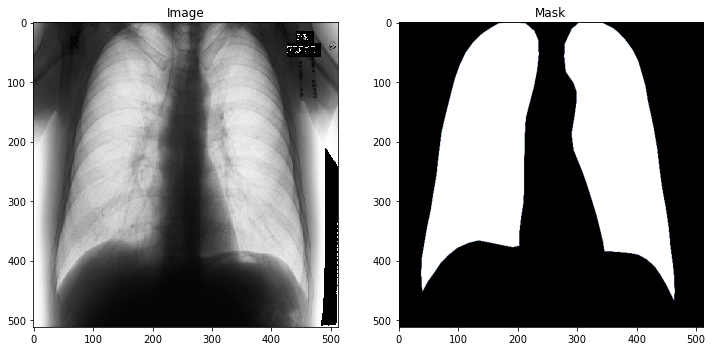

In [12]:
# Assuming img_vol and seg_vol are your image and mask arrays
# Select an example image and its corresponding mask
np.random.seed(2018)
sample_idx = 0
t_img, m_img = img_vol[sample_idx], seg_vol[sample_idx]

# Check if the mask contains meaningful values
if np.max(m_img) == 0:
    print("Warning: The selected mask contains only zeros.")

# Create subplots
fig, (ax_img, ax_mask) = plt.subplots(1, 2, figsize=(12, 6))

# Display the image
ax_img.imshow(np.clip(255 * t_img, 0, 255).astype(np.uint8) if t_img.shape[2] == 3 else t_img[:, :, 0],
              interpolation='none', cmap='bone')
ax_img.set_title("Image")

# Display the mask (if it contains meaningful values)
if np.max(m_img) > 0:
    ax_mask.imshow(m_img[:, :, 0], cmap='bone')
    ax_mask.set_title("Mask")
else:
    ax_mask.set_title("Empty Mask")

plt.show()


## Simple U-Net Model to create lung segmentation

In [16]:
def c2(x_in, nf, strides=1):
    x_out = Conv2D(nf, kernel_size=3, padding='same',
                   kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out
def unet_enc(vol_size, enc_nf, pre_filter=8):
    # Input for color images with shape (512, 512, 3)
    # input_layer = Input(shape=vol_size + (1,), name='EncoderInput')
    input_layer = Input(shape=(512, 512, 3))
    # Down-sample path.
    # x_in = BatchNormalization(name='NormalizeInput', axis=-1, scale=False)(input_layer)  # Set scale=True
    x_in = BatchNormalization(axis=-1)(input_layer)  # Set scale=True
    x_in = c2(x_in, pre_filter, 1)
    x0 = c2(x_in, enc_nf[0], 2)
    x1 = c2(x0, enc_nf[1], 2)
    x2 = c2(x1, enc_nf[2], 2)
    x3 = c2(x2, enc_nf[3], 2)
    model = Model(inputs=[input_layer], outputs=[x_in, x0, x1, x2, x3])
    return model


In [17]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Modify the unet function to accept (512, 512, 1) input
def unet(vol_size, enc_nf, dec_nf, full_size=True, edge_crop=48):
    raw_input = Input(shape=vol_size)
    src = layers.GaussianNoise(0.25)(raw_input)
    enc_model = unet_enc(vol_size, enc_nf)
    x_in, x0, x1, x2, x3 = [s_enc for s_enc in enc_model(src)]

    x = c2(x3, dec_nf[0])
    x = layers.Dropout(0.2)(x)
    x = UpSampling2D()(x)
    x = concatenate([x, x2])
    x = c2(x, dec_nf[1])
    x = layers.Dropout(0.2)(x)
    x = UpSampling2D()(x)
    x = concatenate([x, x1])
    x = c2(x, dec_nf[2])
    x = layers.Dropout(0.2)(x)
    x = UpSampling2D()(x)
    x = concatenate([x, x0])
    x = c2(x, dec_nf[3])
    x = c2(x, dec_nf[4])
    x = layers.Dropout(0.2)(x)
    x = UpSampling2D()(x)
    x = concatenate([x, x_in])
    x = c2(x, dec_nf[5])

    y_seg = Conv2D(3, (1, 1), activation='sigmoid')(x)
    y_seg = layers.Cropping2D((edge_crop, edge_crop))(y_seg)
    y_seg = layers.ZeroPadding2D((edge_crop, edge_crop))(y_seg)
    model = Model(inputs=[raw_input], outputs=[y_seg])
    return model



In [18]:
# use the predefined depths
nf_enc = [16, 32, 32, 32]
nf_dec = [32, 32, 32, 32, 32, 16, 16, 2]

# Modify input shape
input_shape = (512, 512, 3)

net = unet(input_shape, nf_enc, nf_dec)  # Pass input_shape as the first argument
# ensure the model roughly works
a = net.predict([np.zeros((1,) + input_shape)])  # Update input shape here as well
print(a.shape)
net.summary()



1/1 [==============================] - 1s 503ms/step
(1, 512, 512, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise_1 (GaussianNois  (None, 512, 512, 3)  0          ['input_2[0][0]']                
 e)                                                                                               
                                                                                                  
 model (Functional)             [(None, 512, 512, 8  24540       ['gaussian_noise_1[0][0]']       
                      

## Create Training Data Generator

In [19]:
reg_param = 1.0
lr = 2e-4
dice_bce_param = 0.0
use_dice = True

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return dice_bce_param*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

net.compile(optimizer=Adam(lr=lr), 
              loss=[dice_p_bce], 
           metrics = [true_positive_rate, 'binary_accuracy'])

/Users/lanchipham/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Train (114, 512, 512, 3) Test (24, 512, 512, 3) 119.25250784556071 255
Seg (114, 512, 512, 3) 1.0 [0. 1.]


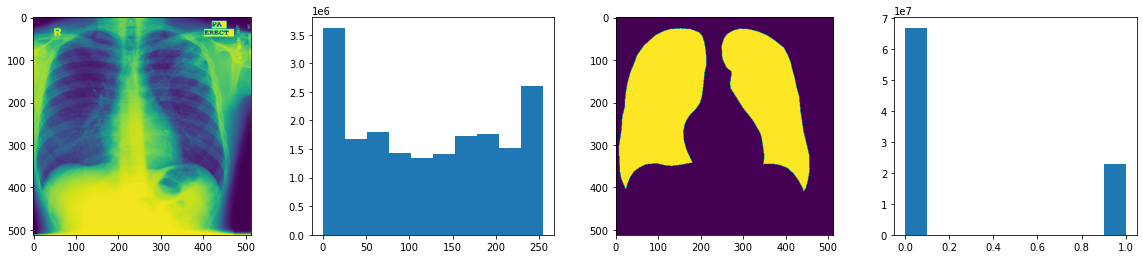

In [20]:
threshold = 0.5
binary_segmentations = (seg_vol > threshold).astype(np.float32)
# seg_vol is your binary segmentation data with shape (512, 512, 3).
num_test_samples = 24

train_vol, test_vol, train_seg, test_seg = train_test_split(img_vol, binary_segmentations, test_size=num_test_samples, random_state=2018)

print('Train', train_vol.shape, 'Test', test_vol.shape, test_vol.mean(), test_vol.max())
print('Seg', train_seg.shape, train_seg.max(), np.unique(train_seg.ravel()))
fig, (ax1, ax1hist, ax2, ax2hist) = plt.subplots(1,4, figsize = (20,4))
ax1.imshow(test_vol[0, :, :, 0])
ax1hist.hist(test_vol.ravel())
ax2.imshow(test_seg[0, :, :, 0]>0.5)
ax2hist.hist(train_seg.ravel());


#### Adding Augmentation

In [21]:

dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 5, 
                  width_shift_range = 0.05, 
                  height_shift_range = 0.05, 
                  shear_range = 0.01,
                  zoom_range = [0.8, 1.2],  
               # anatomically it doesnt make sense, but many images are flipped
                  horizontal_flip = True,  
                  vertical_flip = False,
                  fill_mode = 'nearest',
               data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)

def gen_augmented_pairs(in_vol, in_seg, batch_size=16):
    while True:
        seed = np.random.choice(range(9999))
        # Use the same seed for both input images and segmentation masks
        g_vol = image_gen.flow(in_vol, batch_size=batch_size, seed=seed)
        g_seg = image_gen.flow(in_seg, batch_size=batch_size, seed=seed)
        for i_vol, i_seg in zip(g_vol, g_seg):
            yield i_vol, i_seg


#### Training Data

In [22]:
train_gen = gen_augmented_pairs(train_vol, train_seg, batch_size = 16)
test_gen = gen_augmented_pairs(test_vol, test_seg, batch_size = 16)
X_train, Y_train = next(train_gen)
X_test, Y_test = next(test_gen)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(16, 512, 512, 3) (16, 512, 512, 3)
(16, 512, 512, 3) (16, 512, 512, 3)


In [23]:
# pip install scikit-image


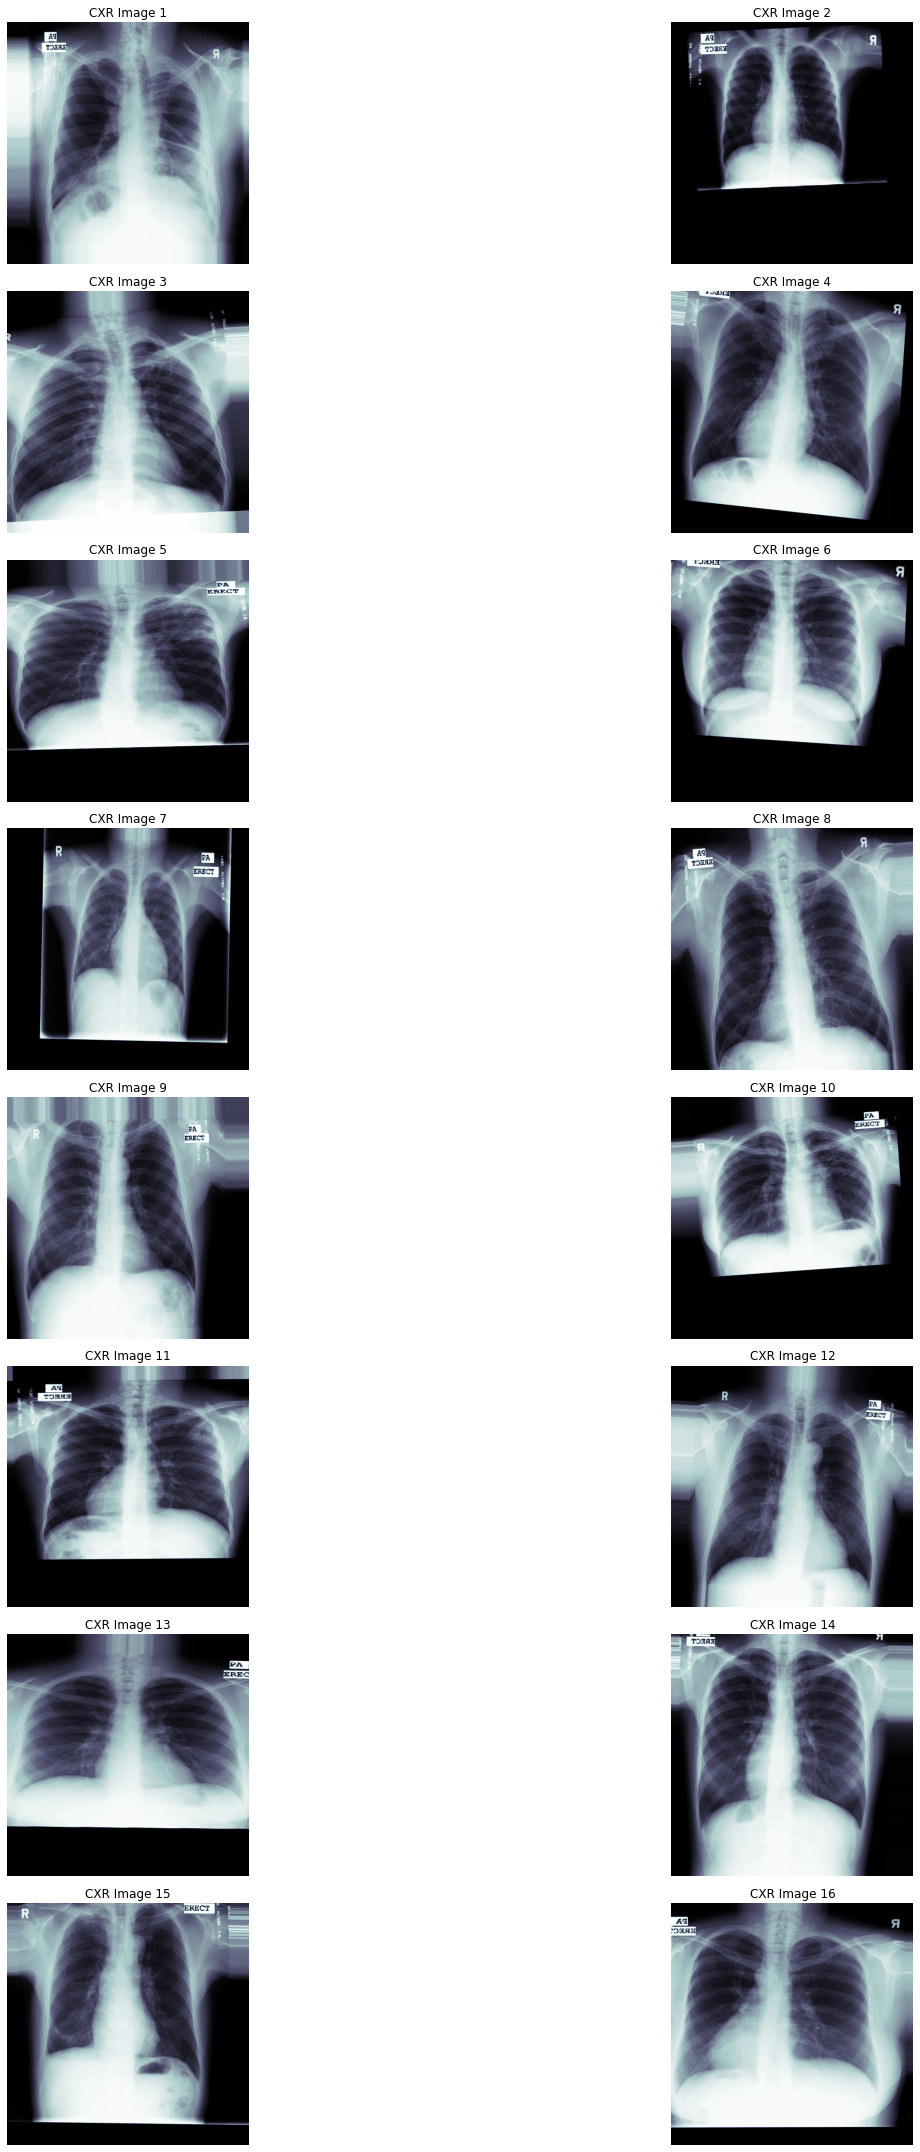

In [24]:

num_images = len(X_train)
num_rows = int(np.ceil(num_images / 2))
fig, axes = plt.subplots(num_rows, 2, figsize=(25, 30))

# Iterate through the images and display them
for i in range(num_images):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.imshow(X_train[i][:, :, 0], cmap='bone')  # Adjust the cmap and channels as needed
    ax.set_title(f'CXR Image {i+1}')
    ax.axis('off')

# Remove empty subplots
for i in range(num_images, num_rows * 2):
    row = i // 2
    col = i % 2
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()



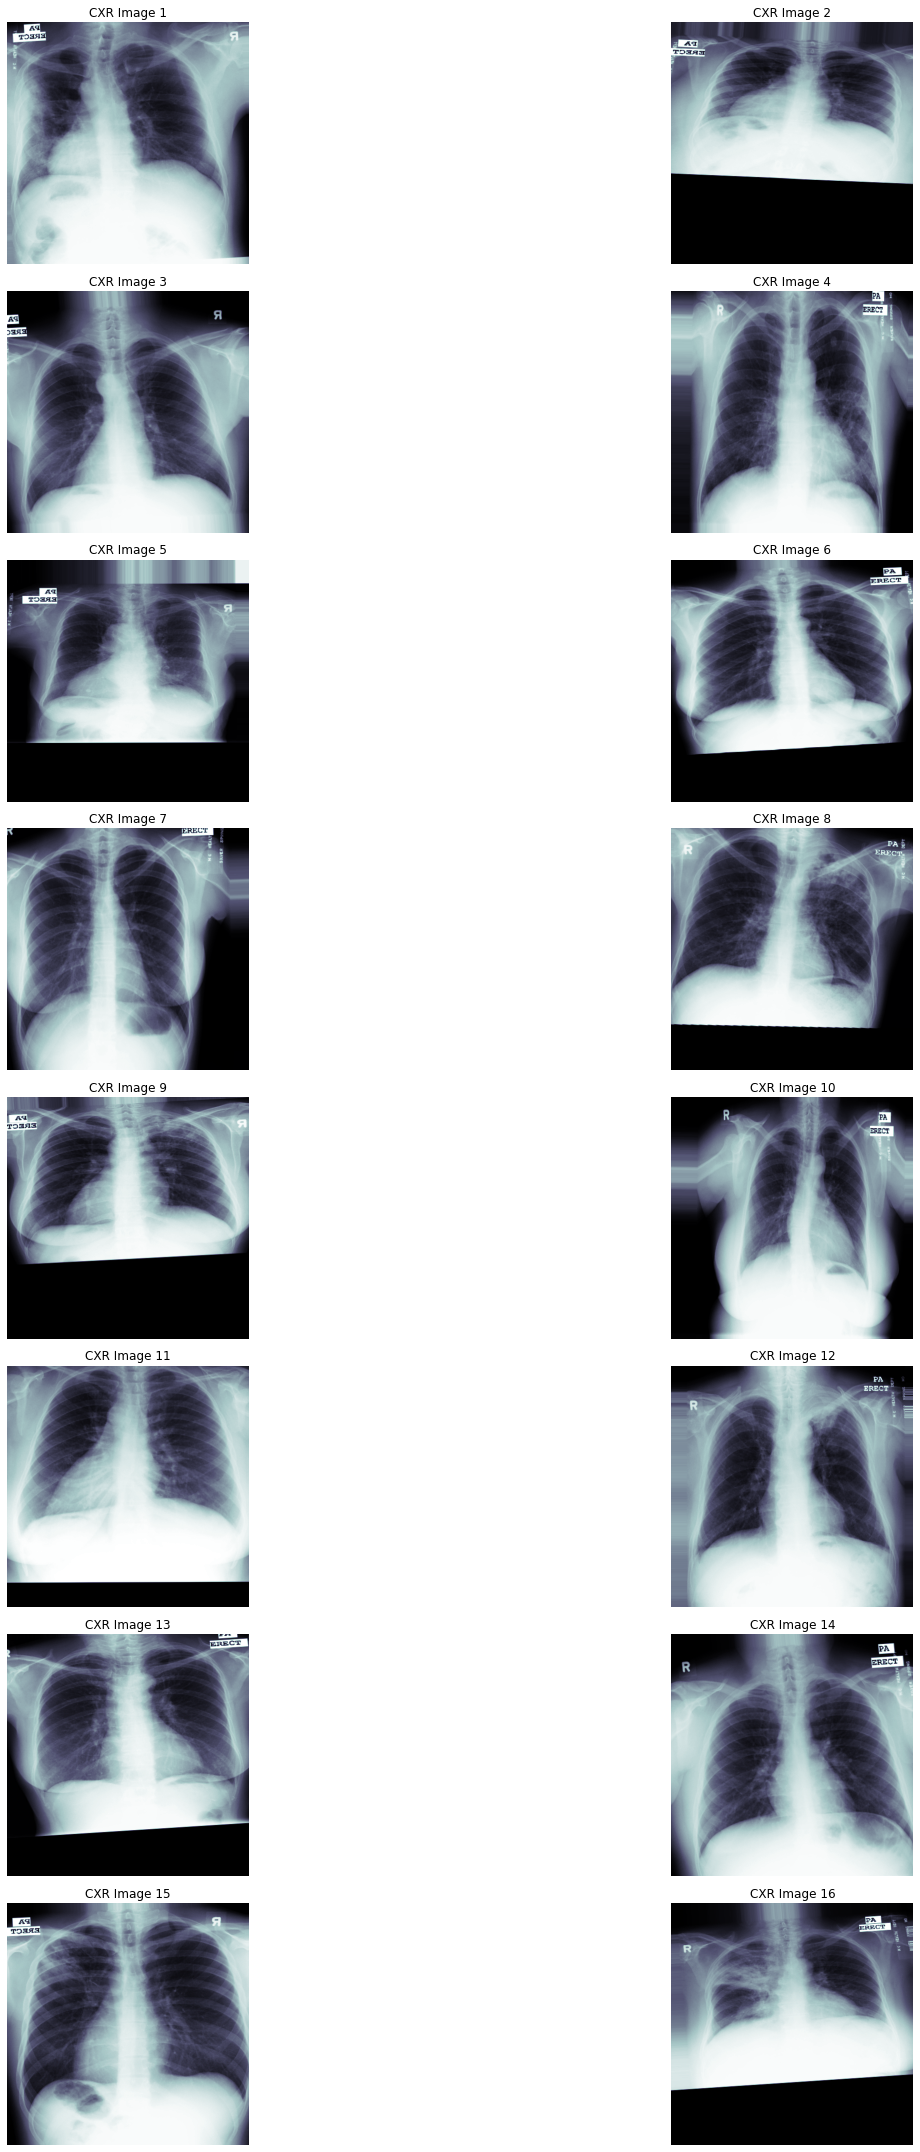

In [25]:
import numpy as np
import matplotlib.pyplot as plt

num_images = len(X_test)
num_rows = int(np.ceil(num_images / 2))
fig, axes = plt.subplots(num_rows, 2, figsize=(25, 30))

# Iterate through the images and display them
for i in range(num_images):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.imshow(X_test[i][:, :, 0], cmap='bone')  # Adjust the cmap and channels as needed
    ax.set_title(f'CXR Image {i+1}')
    ax.axis('off')

# Remove empty subplots
for i in range(num_images, num_rows * 2):
    row = i // 2
    col = i % 2
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()



In [26]:
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import numpy as np

def add_boundary(in_img, in_seg, cmap='bone', norm=True, add_labels=True):
    if norm:
        n_img = (1.0 * in_img - in_img.min()) / (1.1 * (in_img.max() - in_img.min()))
    else:
        n_img = in_img
    if add_labels:
        return label2rgb(image=n_img, label=in_seg.astype(int), bg_label=0)
    else:
        return mark_boundaries(image=n_img, label_img=in_seg.astype(int), color=(0, 1, 0), mode='thick')

def show_full_st(in_img, in_seg, gt_seg):
    if in_img.shape[0] != in_seg.shape[0]:
        raise ValueError("Number of images and segmentations must match.")
    
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))

    for i in range(in_img.shape[0]):
        out_mtg = add_boundary(in_img[i], gt_seg[i] > 0.5)
        axes[0].imshow(out_mtg)
        axes[0].set_title('Ground Truth')

        out_mtg = add_boundary(in_img[i], in_seg[i] > 0.5)
        axes[1].imshow(out_mtg)
        axes[1].set_title('Prediction')

        out_mtg = in_seg[i] - gt_seg[i]
        axes[2].imshow(out_mtg, cmap='RdBu', vmin=-1, vmax=1)
        axes[2].set_title('Difference')

    plt.show()


    # show_full_st(in_img, in_seg, gt_seg)


In [27]:
print (X_test.shape)
print (Y_test.shape)

(16, 512, 512, 3)
(16, 512, 512, 3)


In [28]:
from keras.layers import Input

# Modify the input layers to accept RGB images
input_image = Input(shape=(512, 512, 3), name='ImageInput')
input_encoder = Input(shape=(512, 512, 3), name='EncoderInput')

In [29]:
print (X_test.shape)
print (Y_test.shape)

(16, 512, 512, 3)
(16, 512, 512, 3)


#### Show Untrained Results

In [30]:
# Inside your training or evaluation loop
print("Input image shape:", input_image.shape)

Input image shape: (None, 512, 512, 3)


In [31]:

weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [32]:
print(X_train.shape)
print (test_vol.shape)

(16, 512, 512, 3)
(24, 512, 512, 3)


In [33]:
# Assuming X_train and test_vol are RGB images
# Convert them to grayscale
# X_train_gray = np.array([rgb_to_grayscale(image) for image in X_train])
# test_vol_gray = np.array([rgb_to_grayscale(image) for image in test_vol])

# print("X_train_gray shape:", X_train_gray.shape)
# print("train_seg shape:", train_seg.shape)
# print("test_vol_gray shape:", test_vol_gray.shape)
# print("test_seg shape:", test_seg.shape)

In [34]:
# import numpy as np

# # Calculate how many times to duplicate the grayscale images
# num_duplicates = len(train_seg) // len(X_train_gray)
# X_train_gray_duplicates = np.repeat(X_train_gray, num_duplicates, axis=0)
# print (X_train_gray_duplicates.shape)

# # Ensure X_train_gray_duplicates has the same number of samples as train_seg
# X_train_gray_matched = X_train_gray_duplicates[:len(train_seg)]


In [35]:
# Ensure train_seg has the same number of samples as X_train_gray
# train_seg_matched = train_seg[:len(X_train_gray)]


In [36]:
# Get the first batch of data from the generator
first_batch = next(train_gen)

# Get the shape of the first batch
batch_shape = first_batch[0].shape  

print("train_gen batch shape:", batch_shape)


train_gen batch shape: (16, 512, 512, 3)


In [37]:
# Example: Debugging the generator
for batch_x, batch_y in train_gen:
    print("Batch X shape:", batch_x.shape)
    print("Batch Y shape:", batch_y.shape)
    break  # Print the first batch and exit the loop


Batch X shape: (16, 512, 512, 3)
Batch Y shape: (16, 512, 512, 3)


In [38]:
# Rescale data to the [0, 1] range (if needed)
train_vol = train_vol / 255.0
test_vol = test_vol / 255.0

print("train_vol shape:", train_vol.shape)
print("test_vol shape:", test_vol.shape)

train_vol shape: (114, 512, 512, 3)
test_vol shape: (24, 512, 512, 3)


In [39]:
# Verify data shapes before training
if train_vol.shape[1:] != (512, 512, 3) or train_seg.shape[1:] != (512, 512, 3):
    raise ValueError("Training data dimensions do not match the expected input/output shape.")

if test_vol.shape[1:] != (512, 512, 3) or test_seg.shape[1:] != (512, 512, 3):
    raise ValueError("Testing data dimensions do not match the expected input/output shape.")

# If the dimensions are correct, print a message indicating that the data is ready for training
print("Data dimensions match the expected input/output shape. Training can proceed.")

Data dimensions match the expected input/output shape. Training can proceed.


In [40]:
# Check the scale of your input data
print("Training Data Statistics:")
print("Mean:", np.mean(train_vol))
print("Std Dev:", np.std(train_vol))
print("Min Value:", np.min(train_vol))
print("Max Value:", np.max(train_vol))

# Check the scale of your segmentation data
print("\nTraining Segmentation Data Statistics:")
print("Mean:", np.mean(train_seg))
print("Std Dev:", np.std(train_seg))
print("Min Value:", np.min(train_seg))
print("Max Value:", np.max(train_seg))


Training Data Statistics:
Mean: 0.4368323426825647
Std Dev: 0.3369729862273749
Min Value: 0.0
Max Value: 1.0

Training Segmentation Data Statistics:
Mean: 0.25521314
Std Dev: 0.43599012
Min Value: 0.0
Max Value: 1.0


In [41]:
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise_1 (GaussianNois  (None, 512, 512, 3)  0          ['input_2[0][0]']                
 e)                                                                                               
                                                                                                  
 model (Functional)             [(None, 512, 512, 8  24540       ['gaussian_noise_1[0][0]']       
                                ),                                                          

In [42]:
#Define the optimizer and loss function
optimizer = Adam(learning_rate=0.0001)
loss = 'binary_crossentropy'

# Modify the model architecture to accept (512, 512, 3) input
net = unet((512, 512, 3), nf_enc, nf_dec)
net.compile(optimizer=optimizer, loss=loss) 

# Define the callbacks
callbacks_list = [checkpoint, early, reduceLROnPlat]
BATCH_SIZE = 8

loss_history = net.fit(train_gen,
                       steps_per_epoch=len(train_vol) // BATCH_SIZE,  
                       epochs=25,
                       validation_data=(test_vol, test_seg),
                       callbacks=callbacks_list)

 

Epoch 1/25
14/14 [==============================] - ETA: 0s - loss: 0.7423 
Epoch 1: val_loss improved from inf to 0.58332, saving model to cxr_reg_weights.best.hdf5
14/14 [==============================] - 166s 12s/step - loss: 0.7423 - val_loss: 0.5833 - lr: 1.0000e-04
Epoch 2/25
14/14 [==============================] - ETA: 0s - loss: 0.6341 
Epoch 2: val_loss did not improve from 0.58332
14/14 [==============================] - 201s 14s/step - loss: 0.6341 - val_loss: 0.5839 - lr: 1.0000e-04
Epoch 3/25
14/14 [==============================] - ETA: 0s - loss: 0.6091 
Epoch 3: val_loss did not improve from 0.58332
14/14 [==============================] - 170s 13s/step - loss: 0.6091 - val_loss: 0.5916 - lr: 1.0000e-04
Epoch 4/25
14/14 [==============================] - ETA: 0s - loss: 0.6284 
Epoch 4: val_loss did not improve from 0.58332

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
14/14 [==============================] - 164s 12s/step - loss: 0.6284 

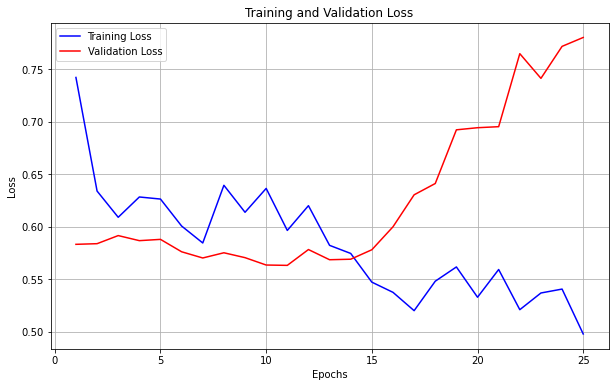

In [44]:
import matplotlib.pyplot as plt

# Extract training and validation loss values from the history
training_loss = loss_history.history['loss']
validation_loss = loss_history.history['val_loss']

# Create a range of epoch numbers
epochs = range(1, len(training_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [46]:
# test_seg = test_seg.astype(int)
# binary_predictions = binary_predictions.astype(int)

# print(np.unique(test_seg))
# print(np.unique(binary_predictions))

In [48]:
# for i in range(10):  # Print predictions for the first 10 samples
#     print(f"Sample {i}: True={test_seg[i]}, Predicted={binary_predictions[i]}")

In [49]:
import numpy as np

# Reshape it to (114, 512, 512, 3)
reshaped_test_data = np.zeros((114, 512, 512, 3))
print (reshaped_test_data.shape)

test_vol_reshaped = reshaped_test_data[:114]  # Assuming you want to keep the first 114 samples
print('Reshaped Test Data Shape:', test_vol_reshaped.shape)


(114, 512, 512, 3)
Reshaped Test Data Shape: (114, 512, 512, 3)


In [51]:
print('Train Data Shape:', train_vol.shape)
print('Train Labels Shape:', train_seg.shape)
print('Test Data Shape:', test_vol_reshaped.shape)
print('Test Labels Shape:', test_seg.shape)


Train Data Shape: (114, 512, 512, 3)
Train Labels Shape: (114, 512, 512, 3)
Test Data Shape: (114, 512, 512, 3)
Test Labels Shape: (24, 512, 512, 3)


In [52]:
# Reshape test_seg to match the shape of binary_predictions
test_seg_flat = test_seg[..., 0].reshape(-1)  # Assuming you want to use the first channel
print('Test Labels Shape:', test_seg_flat.shape)

Test Labels Shape: (6291456,)


1/1 [==============================] - 8s 8s/step
Accuracy: 0.7406725883483887
Confusion Matrix:
[[4659909       0]
 [1631547       0]]


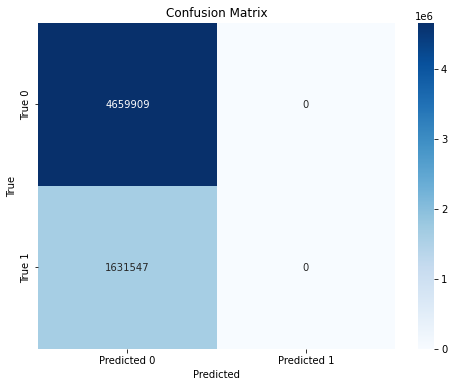

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Make predictions on your test data
predictions = net.predict(test_vol)

# Define the threshold for binary classification
threshold = 0.5

# Convert predictions to binary values based on the threshold
binary_predictions = (predictions > threshold).astype(int)

# Reshape test_seg to match the shape of binary_predictions
test_seg_flat = test_seg[..., 0].reshape(-1)  # Assuming you want to use the first channel

# Flatten the binary_predictions array
binary_predictions_flat = binary_predictions[..., 0].reshape(-1)  # Ensure shape (n_samples,)

# Calculate Accuracy
accuracy = accuracy_score(test_seg_flat, binary_predictions_flat)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_seg_flat, binary_predictions_flat)

# Display the metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


/Users/lanchipham/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Metrics:
Accuracy: 0.7406725883483887
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.5


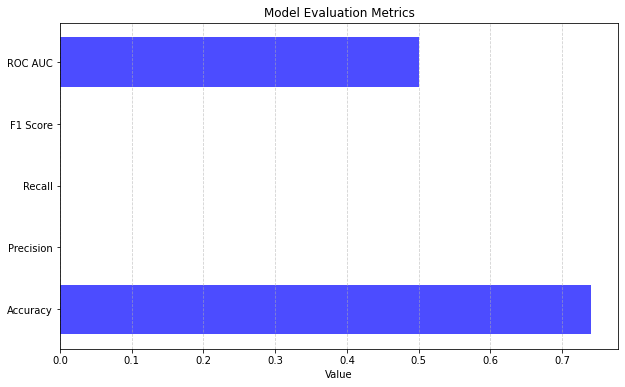

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

threshold = 0.5  # Adjust threshold if necessary
binary_predictions = (predictions > threshold).astype(int)

test_seg_flat = test_seg[..., 0].reshape(-1)  # Assuming you want to use the first channel

# Flatten the binary_predictions array
binary_predictions_flat = binary_predictions[..., 0].reshape(-1)  # Ensure shape (n_samples,)


accuracy = accuracy_score(test_seg_flat, binary_predictions_flat)
precision = precision_score(test_seg_flat, binary_predictions_flat)
recall = recall_score(test_seg_flat, binary_predictions_flat)
f1 = f1_score(test_seg_flat, binary_predictions_flat)
roc_auc = roc_auc_score(test_seg_flat, binary_predictions_flat)

# Print evaluation metrics
print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# Create a bar chart to display evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
values = [accuracy, precision, recall, f1, roc_auc]

# Define the position of bars
y_pos = range(len(metrics))

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(y_pos, values, color='b', alpha=0.7)

# Add metric labels as y-ticks
plt.yticks(y_pos, metrics)

# Add labels, title, and grid
plt.xlabel('Value')
plt.title('Model Evaluation Metrics')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the bar chart
plt.show()